# Install Requirements

In [1]:
# !pip install pandas
# !pip install bs4
# !pip install openpyxl
# !pip install nest_asyncio

# Imports

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import datetime
import re
import random
import asyncio
import aiohttp
import nest_asyncio
import matplotlib.pyplot as plt
from io import StringIO

nest_asyncio.apply()

In [3]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_best-selling_Nintendo_Switch_video_games"
headers = {
    'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}

try:
    response = requests.get(wiki_url, headers=headers)
    response.raise_for_status()
except requests.exceptions.HTTPError as errh:
    print("Http Error:", errh)
except requests.exceptions.ConnectionError as errc:
    print("Error Connecting:", errc)
except requests.exceptions.Timeout as errt:
    print("Timeout Error:", errt)
except requests.exceptions.RequestException as err:
    print("Something went wrong:", err)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    html_table = soup.find('table', {'class': "wikitable"})
    if html_table is None:
        raise ValueError("Could not find the table in the provided URL.")
else:
    print(f"Failed to retrieve the page, status code: {response.status_code}")

In [4]:
switch_sales_df = pd.read_html(StringIO(str(html_table)))[0]
assert not switch_sales_df.empty, "DataFrame is empty"

switch_sales_df['Release date[a]'] = pd.to_datetime(switch_sales_df['Release date[a]'], errors='coerce')
switch_sales_df['As of'] = pd.to_datetime(switch_sales_df['As of'], errors='coerce')

switch_sales_df

,Title,Copies sold,As of,Release date[a],Genre(s),Developer(s),Publisher(s)
10,Ring Fit Adventure,15.38 million[5],2023-03-31,2019-10-18,Exergamerole-playing,Nintendo EPD,Nintendo
11,"Pokémon: Let's Go, Pikachu! and Let's Go, Eevee!",15.07 million[6],2022-12-31,2018-11-16,Role-playing,Game Freak,The Pokémon CompanyNintendo
12,Pokémon Brilliant Diamond and Shining Pearl,15.06 million[7],2022-12-31,2021-11-19,Role-playing,ILCA,The Pokémon CompanyNintendo
13,Pokémon Legends: Arceus,14.83 million[5],2023-03-31,2022-01-28,Action role-playing,Game Freak,The Pokémon CompanyNintendo
15,Splatoon 2,13.60 million[7],2022-12-31,2017-07-21,Third-person shooter,Nintendo EPD,Nintendo


In [5]:
def copies_sold_to_numeric(value):
    value = value.replace('\xa0', ' ').strip()
    parsed_string = re.sub(r'million(\[\w*\])?', '', value)
    parsed_string = re.sub(r'[^\d.]', '', parsed_string)
    try:
        return float(parsed_string) * 1_000_000
    except ValueError:
        raise ValueError(f"Unable to convert '{value}' to a numeric value.")

def convert_date(date_str):
    if isinstance(date_str, pd.Timestamp):
        return date_str
    date_formats = ['%B %d, %Y', '%d %B %Y']
    for fmt in date_formats:
        try:
            return datetime.datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not recognized for: {date_str}")


def create_metacritic_url(title):
    sanitized_title = re.sub(r'[.:,\']', "", title).replace(" ", "-").replace("é", "e").lower()
    return f'https://www.metacritic.com/game/switch/{sanitized_title}/details'

In [6]:
switch_sales_df_formatted = switch_sales_df.assign(
    Release_date=switch_sales_df['Release date[a]'].apply(convert_date),
    As_of=switch_sales_df['As of'].apply(convert_date),
    Copies_sold=switch_sales_df['Copies sold'].apply(copies_sold_to_numeric),
    Metacritic_url=switch_sales_df['Title'].apply(create_metacritic_url)
).drop(columns=['Release date[a]', 'As of', 'Copies sold'], axis=1)

switch_sales_df_formatted.head()

,Title,Genre(s),Developer(s),Publisher(s),Release_date,As_of,Copies_sold,Metacritic_url
10,Ring Fit Adventure,Exergamerole-playing,Nintendo EPD,Nintendo,2019-10-18,2023-03-31,15380000.0,https://www.metacritic.com/game/switch/ring-fi...
11,"Pokémon: Let's Go, Pikachu! and Let's Go, Eevee!",Role-playing,Game Freak,The Pokémon CompanyNintendo,2018-11-16,2022-12-31,15070000.0,https://www.metacritic.com/game/switch/pokemon...
12,Pokémon Brilliant Diamond and Shining Pearl,Role-playing,ILCA,The Pokémon CompanyNintendo,2021-11-19,2022-12-31,15060000.0,https://www.metacritic.com/game/switch/pokemon...
13,Pokémon Legends: Arceus,Action role-playing,Game Freak,The Pokémon CompanyNintendo,2022-01-28,2023-03-31,14830000.0,https://www.metacritic.com/game/switch/pokemon...
15,Splatoon 2,Third-person shooter,Nintendo EPD,Nintendo,2017-07-21,2022-12-31,13600000.0,https://www.metacritic.com/game/switch/splatoo...


In [8]:
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.121 Safari/537.36'
}
MIN_DELAY = 2
MAX_DELAY = 4

async def fetch_metacritic_html(session, url):
    try:
        async with session.get(url, headers=HEADERS) as response:
            if response.status == 200:
                return await response.text()
            else:
                return None
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

async def scrape_metacritic(html):
    soup = BeautifulSoup(html, 'html.parser')

    def get_text(selector):
        element = soup.select_one(selector)
        return element.text.strip() if element else None

    try:
        description = get_text(".summary_detail.product_summary span.data")
        meta_score = float(get_text(".metascore_wrap.feature_metascore span") or 0)
        meta_ratings = int(re.findall(r'\d+', get_text(".metascore_wrap.feature_metascore .summary p .count a span") or '0')[0])
        user_score = float(get_text(".userscore_wrap.feature_userscore a.metascore_anchor div") or 0)
        user_ratings = int(re.findall(r'\d+', get_text(".userscore_wrap.feature_userscore .summary .count") or '0')[0])
    except (TypeError, ValueError):
        return None

    return {
        'description': description, 
        'meta_score': meta_score, 
        'meta_ratings': meta_ratings, 
        'user_score': user_score, 
        'user_ratings': user_ratings
    }

async def fetch_metacritic_data(urls):
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_metacritic_html(session, url) for url in urls]
        html_list = await asyncio.gather(*tasks)

        results = []
        for url, html in zip(urls, html_list):
            if html:
                data = await scrape_metacritic(html)
                if data:
                    data.update({'Metacritic_url': url, 'status_code': 200, 'parsed': True})
                else:
                    data = {'Metacritic_url': url, 'status_code': 200, 'parsed': False}
            else:
                data = {'Metacritic_url': url, 'status_code': None, 'parsed': False}
            results.append(data)
            await asyncio.sleep(random.uniform(MIN_DELAY, MAX_DELAY))
        
    return pd.DataFrame(results)

In [9]:
urls = switch_sales_df_formatted["Metacritic_url"].tolist()

loop = asyncio.get_event_loop()
reviews_df = loop.run_until_complete(fetch_metacritic_data(urls))

reviews_df.head()

,description,meta_score,meta_ratings,user_score,user_ratings,Metacritic_url,status_code,parsed
0,NaN,0.0,0.0,0.0,0.0,https://www.metacritic.com/game/switch/ring-fi...,200.0,True
1,NaN,NaN,NaN,NaN,NaN,https://www.metacritic.com/game/switch/pokemon...,NaN,False
2,NaN,NaN,NaN,NaN,NaN,https://www.metacritic.com/game/switch/pokemon...,NaN,False
3,NaN,0.0,0.0,0.0,0.0,https://www.metacritic.com/game/switch/pokemon...,200.0,True
4,NaN,0.0,0.0,0.0,0.0,https://www.metacritic.com/game/switch/splatoo...,200.0,True


In [11]:
switch_sales_reviews_df = pd.merge(switch_sales_df_formatted, reviews_df, on="Metacritic_url", how="left")

if 'meta_score' in switch_sales_reviews_df.columns and 'user_score' in switch_sales_reviews_df.columns:
    switch_sales_reviews_df['meta_score'] = switch_sales_reviews_df['meta_score'].fillna(switch_sales_reviews_df['meta_score'].mean())
    switch_sales_reviews_df['user_score'] = switch_sales_reviews_df['user_score'].fillna(switch_sales_reviews_df['user_score'].median())

    switch_sales_reviews_df['meta_score_normalized'] = switch_sales_reviews_df['meta_score'].apply(lambda x: x * 10 if x <= 10 else x)
    switch_sales_reviews_df['user_score_normalized'] = switch_sales_reviews_df['user_score'].apply(lambda x: x * 10 if x <= 10 else x)

    switch_sales_reviews_df['score_difference'] = switch_sales_reviews_df['meta_score_normalized'] - switch_sales_reviews_df['user_score_normalized']
    switch_sales_reviews_df['combined_score'] = (switch_sales_reviews_df['meta_score_normalized'] + switch_sales_reviews_df['user_score_normalized']) / 2
else:
    print("Warning: 'meta_score' or 'user_score' columns not found. Skipping related processing steps.")

switch_sales_reviews_df.head()

,Title,Genre(s),Developer(s),Publisher(s),Release_date,As_of,Copies_sold,Metacritic_url,description,meta_score,meta_ratings,user_score,user_ratings,status_code,parsed,meta_score_normalized,user_score_normalized,score_difference,combined_score
0,Ring Fit Adventure,Exergamerole-playing,Nintendo EPD,Nintendo,2019-10-18,2023-03-31,15380000.0,https://www.metacritic.com/game/switch/ring-fi...,NaN,0.0,0.0,0.0,0.0,200.0,True,0.0,0.0,0.0,0.0
1,"Pokémon: Let's Go, Pikachu! and Let's Go, Eevee!",Role-playing,Game Freak,The Pokémon CompanyNintendo,2018-11-16,2022-12-31,15070000.0,https://www.metacritic.com/game/switch/pokemon...,NaN,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0
2,Pokémon Brilliant Diamond and Shining Pearl,Role-playing,ILCA,The Pokémon CompanyNintendo,2021-11-19,2022-12-31,15060000.0,https://www.metacritic.com/game/switch/pokemon...,NaN,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0
3,Pokémon Legends: Arceus,Action role-playing,Game Freak,The Pokémon CompanyNintendo,2022-01-28,2023-03-31,14830000.0,https://www.metacritic.com/game/switch/pokemon...,NaN,0.0,0.0,0.0,0.0,200.0,True,0.0,0.0,0.0,0.0
4,Splatoon 2,Third-person shooter,Nintendo EPD,Nintendo,2017-07-21,2022-12-31,13600000.0,https://www.metacritic.com/game/switch/splatoo...,NaN,0.0,0.0,0.0,0.0,200.0,True,0.0,0.0,0.0,0.0


In [12]:
switch_sales_reviews_df.drop_duplicates(subset=['Title'], inplace=True)

switch_sales_reviews_df.sort_values(by='Copies_sold', ascending=False, inplace=True)

switch_sales_reviews_df['Sales_Rank'] = switch_sales_reviews_df['Copies_sold'].rank(ascending=False, method='min').astype(int)

switch_sales_reviews_df.rename(columns={
    'Title': 'Game_Title',
    'Copies_sold': 'Total_Copies_Sold',
    'Release_date': 'Release_Date',
    'As_of': 'As_Of',
    'description': 'Game_Description'
}, inplace=True)

switch_sales_reviews_df.head()

,Game_Title,Genre(s),Developer(s),Publisher(s),Release_Date,As_Of,Total_Copies_Sold,Metacritic_url,Game_Description,meta_score,meta_ratings,user_score,user_ratings,status_code,parsed,meta_score_normalized,user_score_normalized,score_difference,combined_score,Sales_Rank
0,Ring Fit Adventure,Exergamerole-playing,Nintendo EPD,Nintendo,2019-10-18,2023-03-31,15380000.0,https://www.metacritic.com/game/switch/ring-fi...,NaN,0.0,0.0,0.0,0.0,200.0,True,0.0,0.0,0.0,0.0,1
1,"Pokémon: Let's Go, Pikachu! and Let's Go, Eevee!",Role-playing,Game Freak,The Pokémon CompanyNintendo,2018-11-16,2022-12-31,15070000.0,https://www.metacritic.com/game/switch/pokemon...,NaN,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0,2
2,Pokémon Brilliant Diamond and Shining Pearl,Role-playing,ILCA,The Pokémon CompanyNintendo,2021-11-19,2022-12-31,15060000.0,https://www.metacritic.com/game/switch/pokemon...,NaN,0.0,NaN,0.0,NaN,NaN,False,0.0,0.0,0.0,0.0,3
3,Pokémon Legends: Arceus,Action role-playing,Game Freak,The Pokémon CompanyNintendo,2022-01-28,2023-03-31,14830000.0,https://www.metacritic.com/game/switch/pokemon...,NaN,0.0,0.0,0.0,0.0,200.0,True,0.0,0.0,0.0,0.0,4
4,Splatoon 2,Third-person shooter,Nintendo EPD,Nintendo,2017-07-21,2022-12-31,13600000.0,https://www.metacritic.com/game/switch/splatoo...,NaN,0.0,0.0,0.0,0.0,200.0,True,0.0,0.0,0.0,0.0,5


In [14]:
output_file = "nintendo_switch_sales_and_reviews.xlsx"
switch_sales_reviews_df.to_excel(output_file, index=False)
print(f"Data saved to {output_file}")

Data saved to nintendo_switch_sales_and_reviews.xlsx


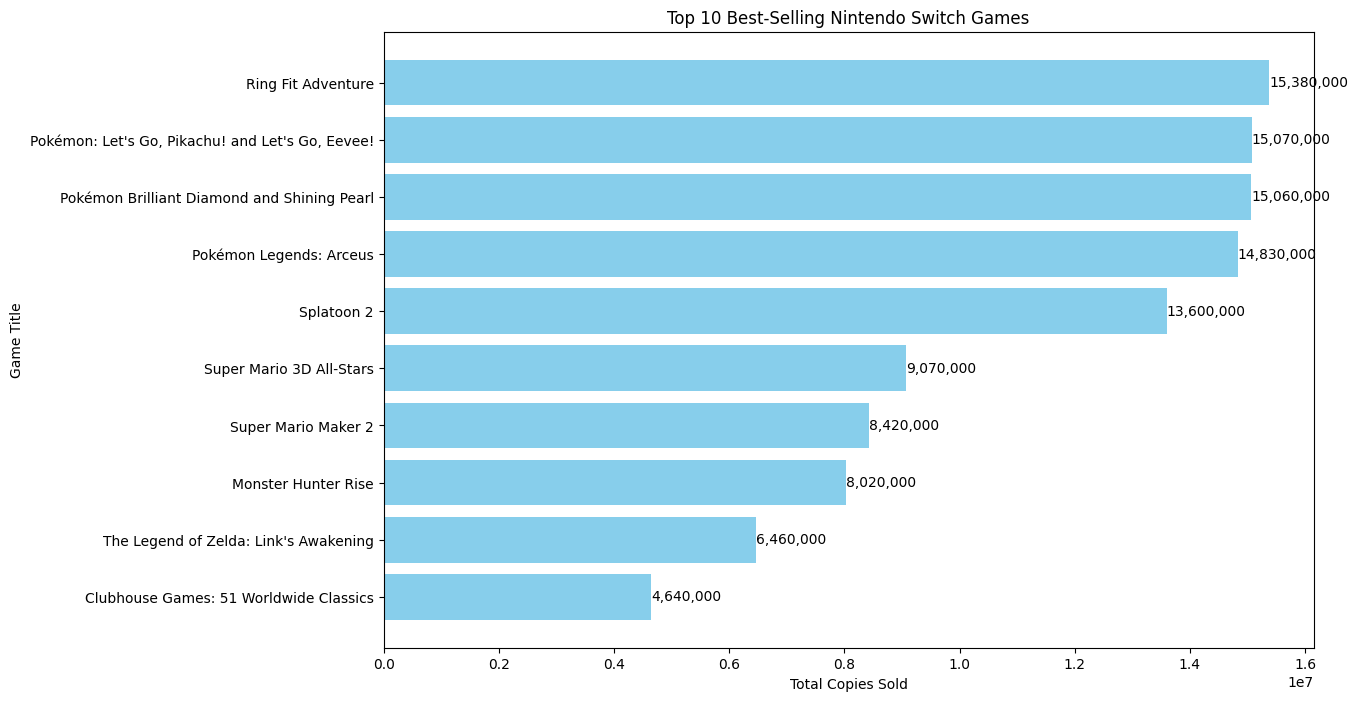

In [13]:
top_10 = switch_sales_reviews_df.head(10)

plt.figure(figsize=(12, 8))
plt.barh(top_10['Game_Title'], top_10['Total_Copies_Sold'], color='skyblue')

for index, value in enumerate(top_10['Total_Copies_Sold']):
    plt.text(value, index, f'{value:,.0f}', va='center', ha='left', color='black')

plt.xlabel('Total Copies Sold')
plt.ylabel('Game Title')
plt.title('Top 10 Best-Selling Nintendo Switch Games')

plt.gca().invert_yaxis()

plt.show()